In [2]:
import utils
import plotting
import postprocessing
import corrections

from utils import CUT_MAX_VAL
from hh_vars import (
    years,
    sig_key,
    data_key,
    qcd_key,
    bg_keys,
    samples,
    txbb_wps,
    jec_shifts,
    jmsr_shifts,
)
from postprocessing import (
    shape_var,
    shape_bins,
    blind_window,
    selection_regions,
    selection_regions_label,
    # selection_regions_year,
)

import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
from hist import Hist

import os
from copy import deepcopy
from inspect import cleandoc
import warnings

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

# ignore these because they don't seem to apply
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
%load_ext autoreload
%autoreload 2

In [26]:
MAIN_DIR = "../../../"
samples_dir = f"{MAIN_DIR}/../data/skimmer/Feb24"
signal_samples_dir = f"{MAIN_DIR}/../data/skimmer/Feb24"
year = "2017"

plot_dir = "../../../plots/PostProcessing/Feb28"
templates_dir = "templates/Feb28/"
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {plot_dir}/cutflows/")
_ = os.system(f"mkdir -p {plot_dir}/templates/")
# _ = os.system(f"mkdir -p {templates_dir}")

Load samples

In [12]:
filters = postprocessing.filters
systematics = {}

# save cutflow as pandas table
cutflow = pd.DataFrame(index=list(samples.keys()))

# utils.remove_empty_parquets(samples_dir, year)
events_dict = utils.load_samples(signal_samples_dir, {sig_key: samples[sig_key]}, year, filters)
events_dict |= utils.load_samples(
    samples_dir, {k: samples[k] for k in samples.keys() - [sig_key]}, year, filters
)

utils.add_to_cutflow(events_dict, "BDTPreselection", "weight", cutflow)

print("")
# print weighted sample yields
for sample in events_dict:
    tot_weight = np.sum(events_dict[sample]["weight"].values)
    print(f"Pre-selection {sample} yield: {tot_weight:.2f}")

Loaded GluGluToHHTobbVV_node_cHHH1                       : 147046 entries
Loaded JetHT_Run2017D                                    : 125980 entries
Loaded JetHT_Run2017C                                    : 263891 entries
Loaded JetHT_Run2017B                                    : 92308 entries
Loaded JetHT_Run2017E                                    : 181075 entries
Loaded JetHT_Run2017F                                    : 445476 entries
Loaded ST_s-channel_4f_hadronicDecays                    : 19893 entries
Loaded ST_tW_top_5f_inclusiveDecays                      : 16222 entries
Loaded ST_tW_antitop_5f_inclusiveDecays                  : 11969 entries
Loaded ST_s-channel_4f_leptonDecays                      : 10241 entries
Loaded ST_t-channel_antitop_4f_InclusiveDecays           : 31411 entries
Loaded QCD_HT300to500                                    : 15 entries
Loaded QCD_HT200to300                                    : 0 entries
Loaded QCD_HT700to1000                               

Scale factors and bb VV assignment

In [13]:
postprocessing.apply_weights(events_dict, year, cutflow)
bb_masks = postprocessing.bb_VV_assignment(events_dict)
events_dict[sig_key] = postprocessing.postprocess_lpsfs(events_dict[sig_key])
cutflow


QCD_SCALE_FACTOR = 0.8141631998851222


,BDTPreselection,TriggerEffs,QCD SF
HHbbVV,3.080614e+00,1.777757e+00,1.777757e+00
QCD,2.297340e+06,1.194347e+06,9.723930e+05
TT,1.393617e+05,9.016284e+04,9.016284e+04
ST,9.979986e+03,6.717597e+03,6.717597e+03
V+Jets,6.347558e+04,3.886090e+04,3.886090e+04
Diboson,9.467148e+02,5.956462e+02,5.956462e+02
Data,1.108730e+06,1.108730e+06,1.108730e+06


In [14]:
postprocessing.load_bdt_preds(
    events_dict, year, f"{samples_dir}/inferences/", list(samples.keys()), jec_jmsr_shifts=True
)

Overall BDT SF

In [16]:
sel, cf = utils.make_selection(
    selection_regions[year]["BDTOnly"], events_dict, bb_masks, prev_cutflow=cutflow
)
lp_sf, unc, uncs = postprocessing.get_lpsf(events_dict[sig_key], sel[sig_key])
print(f"BDT Scale Factor: {lp_sf:.2f} ± {unc:.2f}")
print(uncs)
systematics["lp_sf_unc"] = unc / lp_sf
cf

BDT Scale Factor: 0.82 ± 0.15
{'syst_unc': 0.14195442334809535, 'stat_unc': 0.03553479891157332, 'sj_pt_unc': 0.004660662592473464, 'sj_matching_unc': 0.11200010721561059}


,BDTPreselection,TriggerEffs,QCD SF,BDTScore > 0.99
HHbbVV,3.080614e+00,1.777757e+00,1.777757e+00,0.338860
QCD,2.297340e+06,1.194347e+06,9.723930e+05,720.153977
TT,1.393617e+05,9.016284e+04,9.016284e+04,186.938381
ST,9.979986e+03,6.717597e+03,6.717597e+03,17.328825
V+Jets,6.347558e+04,3.886090e+04,3.886090e+04,74.629383
Diboson,9.467148e+02,5.956462e+02,5.956462e+02,0.410420
Data,1.108730e+06,1.108730e+06,1.108730e+06,1415.000000


Templates

pass

Cutflow:
          BDTPreselection   TriggerEffs        QCD SF  BDTScore > 0.99  \
HHbbVV      3.080614e+00  1.777757e+00  1.777757e+00         0.338860   
QCD         2.297340e+06  1.194347e+06  9.723930e+05       720.153977   
TT          1.393617e+05  9.016284e+04  9.016284e+04       186.938381   
ST          9.979986e+03  6.717597e+03  6.717597e+03        17.328825   
V+Jets      6.347558e+04  3.886090e+04  3.886090e+04        74.629383   
Diboson     9.467148e+02  5.956462e+02  5.956462e+02         0.410420   
Data        1.108730e+06  1.108730e+06  1.108730e+06      1415.000000   

         bbFatJetParticleNetMD_Txbb > 0.987  
HHbbVV                             0.161608  
QCD                               29.151636  
TT                                14.172425  
ST                                 1.322972  
V+Jets                            15.473229  
Diboson                            0.000000  
Data                             140.000000  
Trigger SF Unc.: 0.025198905580

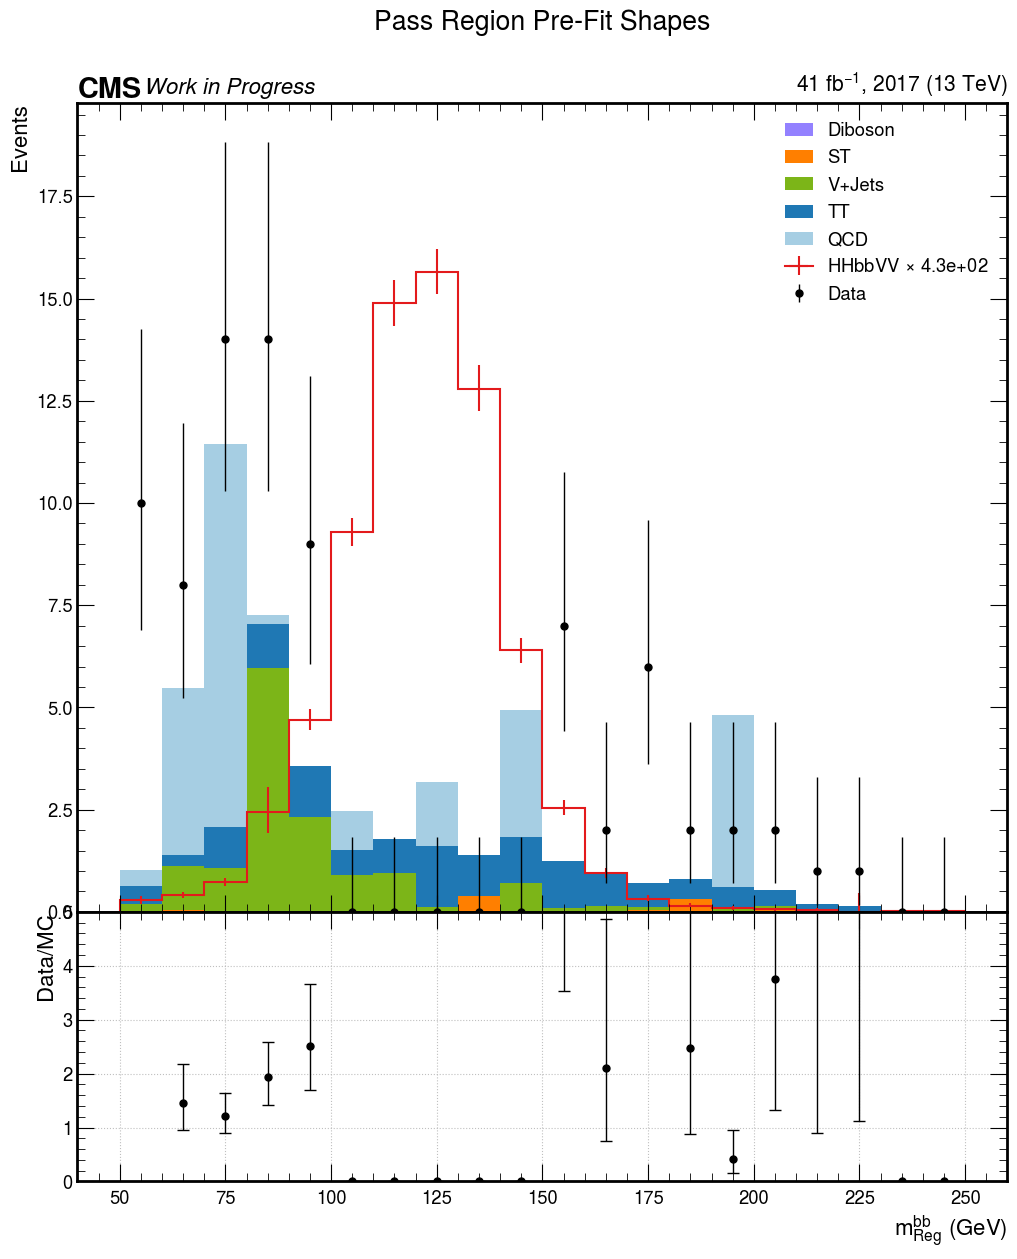

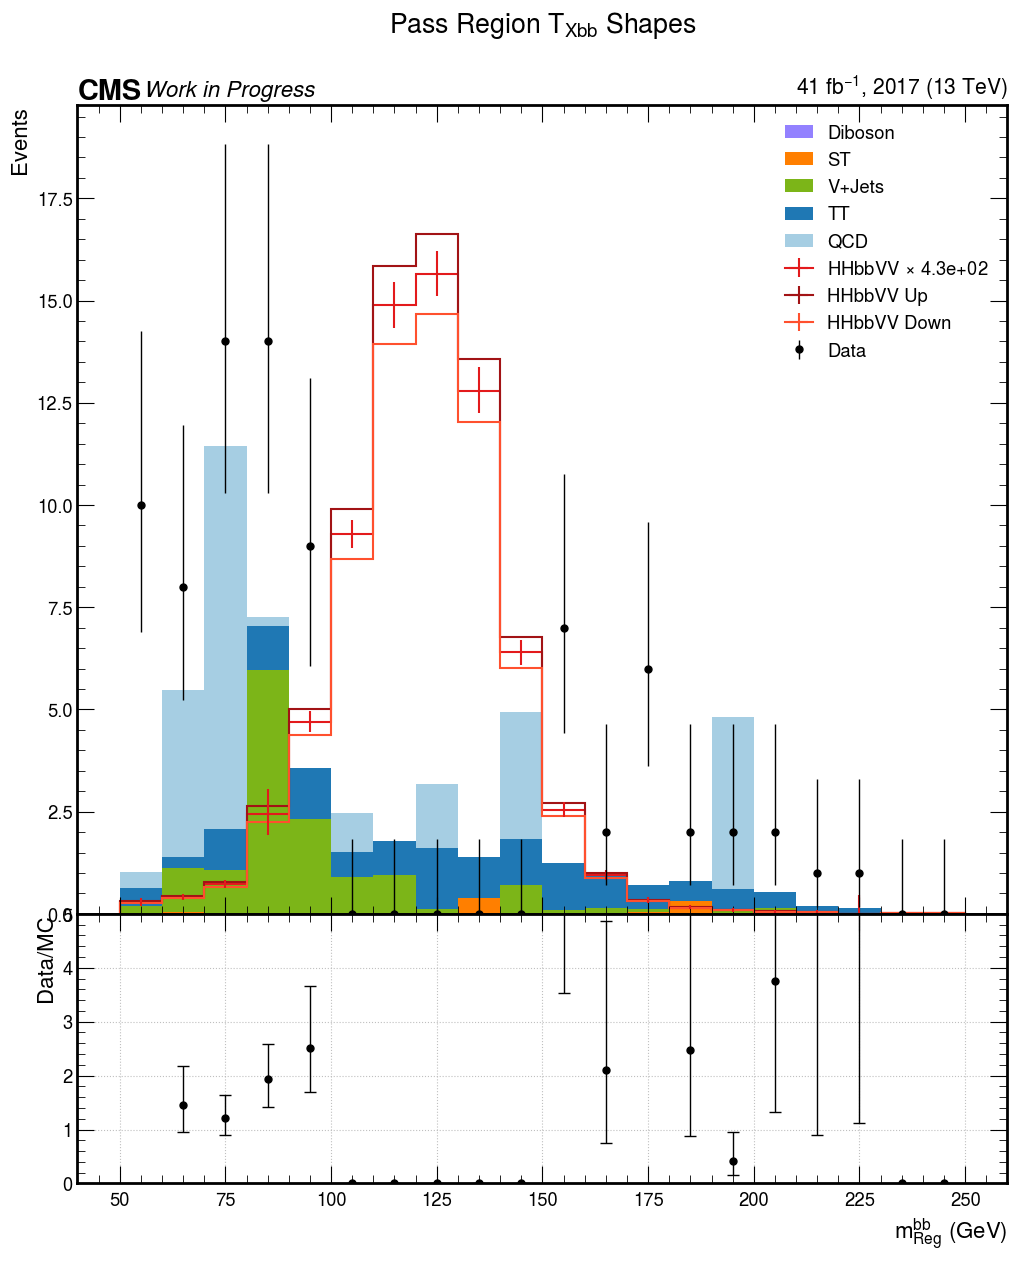

fail

Cutflow:
          BDTPreselection   TriggerEffs        QCD SF  \
HHbbVV      3.080614e+00  1.777757e+00  1.777757e+00   
QCD         2.297340e+06  1.194347e+06  9.723930e+05   
TT          1.393617e+05  9.016284e+04  9.016284e+04   
ST          9.979986e+03  6.717597e+03  6.717597e+03   
V+Jets      6.347558e+04  3.886090e+04  3.886090e+04   
Diboson     9.467148e+02  5.956462e+02  5.956462e+02   
Data        1.108730e+06  1.108730e+06  1.108730e+06   

         bbFatJetParticleNetMD_Txbb > 0.8  bbFatJetParticleNetMD_Txbb < 0.987  
HHbbVV                       1.777757e+00                        9.603467e-01  
QCD                          9.723930e+05                        8.930165e+05  
TT                           9.016284e+04                        8.370478e+04  
ST                           6.717597e+03                        6.254504e+03  
V+Jets                       3.886090e+04                        3.132061e+04  
Diboson                      5.956462e+02              

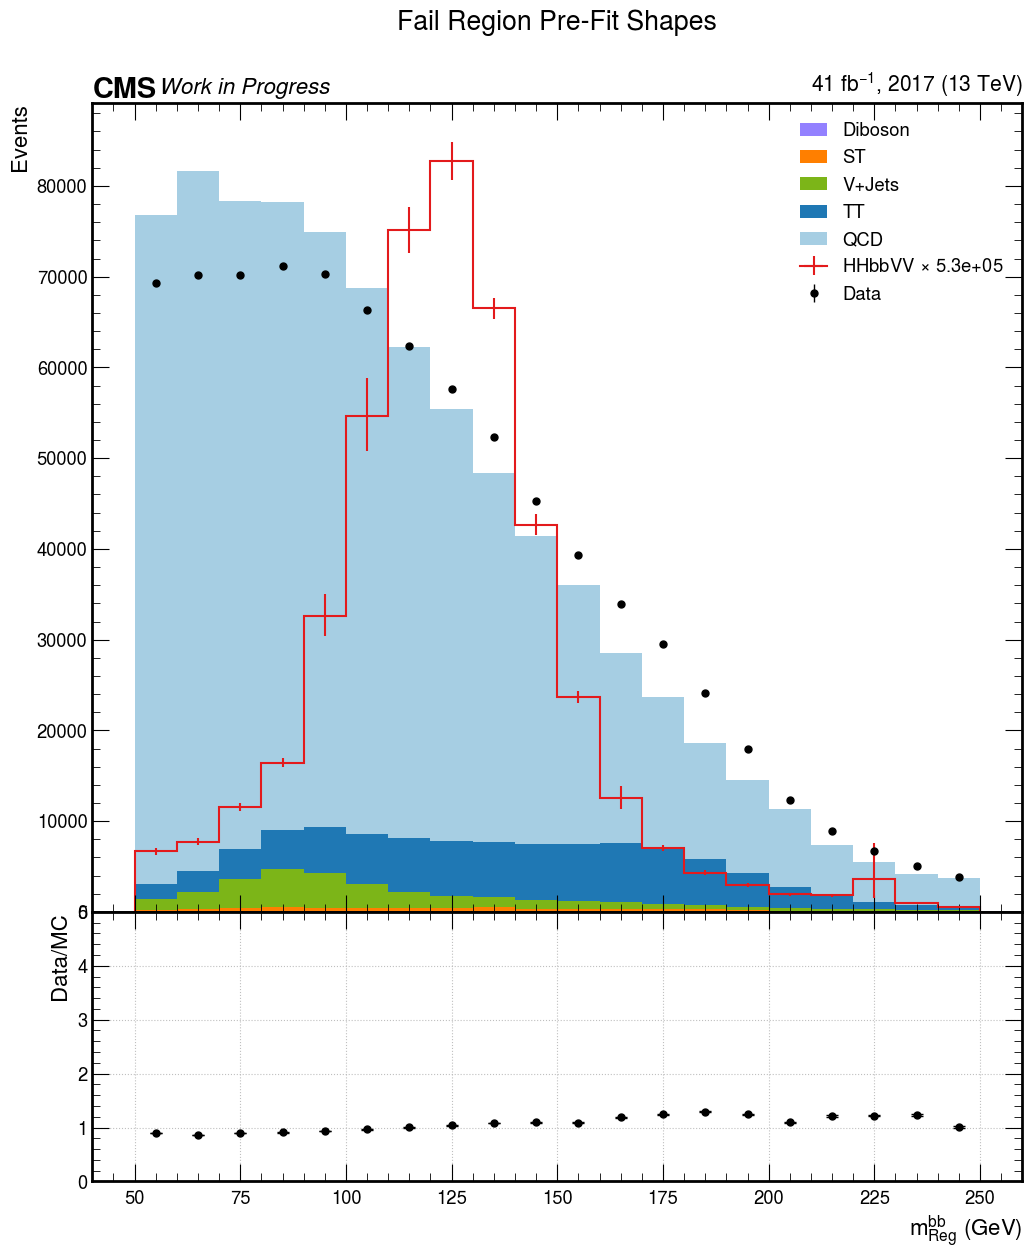

({'pass': Hist(
    StrCategory(['HHbbVV', 'Data', 'ST', 'QCD', 'TT', 'Diboson', 'V+Jets', 'HHbbVV_txbb_down', 'HHbbVV_txbb_up'], name='Sample'),
    Regular(20, 50, 250, name='bbFatJetMsd', label='$m^{bb}_{Reg}$ (GeV)'),
    storage=Weight()) # Sum: WeightedSum(value=130.471, variance=178.899) (WeightedSum(value=158.637, variance=213.229) with flow),
  'fail': Hist(
    StrCategory(['HHbbVV', 'Data', 'ST', 'QCD', 'TT', 'Diboson', 'V+Jets'], name='Sample'),
    Regular(20, 50, 250, name='bbFatJetMsd', label='$m^{bb}_{Reg}$ (GeV)'),
    storage=Weight()) # Sum: WeightedSum(value=1.63673e+06, variance=1.82098e+07) (WeightedSum(value=2.03873e+06, variance=2.23626e+07) with flow)},
 {'pass': {'trig_unc': 0.02519890558032111},
  'fail': {'trig_unc': 0.006190808302948323}})

In [27]:
postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    selection_regions[year],
    shape_var,
    shape_bins,
    blind_window,
    plot_dir=plot_dir,
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    show=True,
)

In [ ]:
templates = {}

for jshift in [""] + jec_shifts + jmsr_shifts:
    print(jshift)
    ttemps, tsyst = postprocessing.get_templates(
        events_dict,
        bb_masks,
        year,
        selection_regions[year],
        shape_var,
        shape_bins,
        blind_window,
        plot_dir=plot_dir,
        prev_cutflow=cutflow,
        weight_shifts=postprocessing.weight_shifts,
        jshift=jshift,
        show=False,
    )

    templates = {**templates, **ttemps}
    systematics = {**systematics, **tsyst}

In [ ]:
systematics